# MIRI FM etalon line identification

### This notebook is used to save all fitted centers and properties of fitted etalon lines observed with the MIRI MRS.

In [1]:
# import modules
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
from datetime import date
import scipy.interpolate as scp_interpolate
from scipy.optimize import curve_fit
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# > Set directories
user = "yannis" # "yannis"
if user == "alvaro":
    workDir = "./"
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"
cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"
MRSWaveCalDir = workDir+"MRSWaveCal/"
FTSlinefits   = MRSWaveCalDir+"FTS_ET_linefits/"

In [3]:
# give analysis inputs
band = '2A'                     # spectral band under investigation
islice = 2                     # slice number (equivalent to beta position)

In [4]:
# open files to store information
save_et1a = open('data/Band'+str(band)+'_ET1A_slice'+str(islice)+'.txt', 'w')
save_et1a.write('# Band '+str(band)+'   Etalon 1A   Slice '+str(islice)+'\n')
save_et1a.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_et1a.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_et1a.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_et1a.write('#    alpha       x  y      center         FWHM          skewness\n')

save_et1b = open('data/Band'+str(band)+'_ET1B_slice'+str(islice)+'.txt', 'w')
save_et1b.write('# Band '+str(band)+'   Etalon 1B   Slice '+str(islice)+'\n')
save_et1b.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_et1b.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_et1b.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_et1b.write('#    alpha       x  y      center         FWHM          skewness\n')

In [5]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

In [6]:
# To account for the problematic lines at the top of the distorion maps
## WARNING: This should only be done for band 1C (and only if the distortion CDP version 06.04.00 is used, not the CDP7 version).
if band == "1C":
    d2cMaps['sliceMap'][0,:] = d2cMaps['sliceMap'][1,:]
    d2cMaps['alphaMap'][0,:] = d2cMaps['alphaMap'][1,:]
    d2cMaps['sliceMap'][-1,:] = d2cMaps['sliceMap'][-2,:]
    d2cMaps['alphaMap'][-1,:] = d2cMaps['alphaMap'][-2,:]

In [7]:
# Load etalon MRS and RAL FTS data files and data, and subtract BKG
# Etalon_1A FM data
sci_etalon1A_img,bkg_etalon1A_img = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1A',output='img')
# Etalon_1B FM data
sci_etalon1B_img,bkg_etalon1B_img = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl2path,band,etalon='ET1B',output='img')

etalon1A_img = sci_etalon1A_img-bkg_etalon1A_img
etalon1B_img = sci_etalon1B_img-bkg_etalon1B_img

# FTS Etalon data (need to extrapolate to operating temperatures (~35 K)?)
FTS_ET1A_linefits_file = FTSlinefits+'RAL_FTS_ET1A_FITPARAMS_07.01.00.fits'
FTS_ET1B_linefits_file = FTSlinefits+'RAL_FTS_ET1B_FITPARAMS_07.01.00.fits'

In [8]:
# Traces for each isoalpha are identified based on the following criteria:
if band == "2A":
    alpha_high = 2.2
    alpha_low = -1.9
    thres_e1a=0.2
    min_dist_e1a=9
    thres_e1b=0.2
    min_dist_e1b=9

In [9]:
alphas_inslice = funcs.slice_alphapositions(band,d2cMaps,sliceID=islice)
alphas_inslice = np.append(0,alphas_inslice)  # To include alpha=0, and put it at the beginning of the array

inds_al = np.where((alphas_inslice < alpha_high) & (alphas_inslice > alpha_low))  # we cut to this range to avoid issues with the edges of the slices.
alphas_inslice = alphas_inslice[inds_al]

print 'Along-slice positions: {} arcseconds'.format(alphas_inslice)

Along-slice positions: [ 0.         -1.75913182 -1.58126182 -1.40339182 -1.22552182 -1.04765182
 -0.86978182 -0.69191182 -0.51404182 -0.33617182 -0.15830182  0.01956818
  0.19743818  0.37530818  0.55317818  0.73104818  0.90891818  1.08678818
  1.26465818  1.44252818  1.62039818  1.79826818  1.97613818  2.15400818] arcseconds


### Perform analysis for single trace (use for debugging, if need be)

<IPython.core.display.Javascript object>


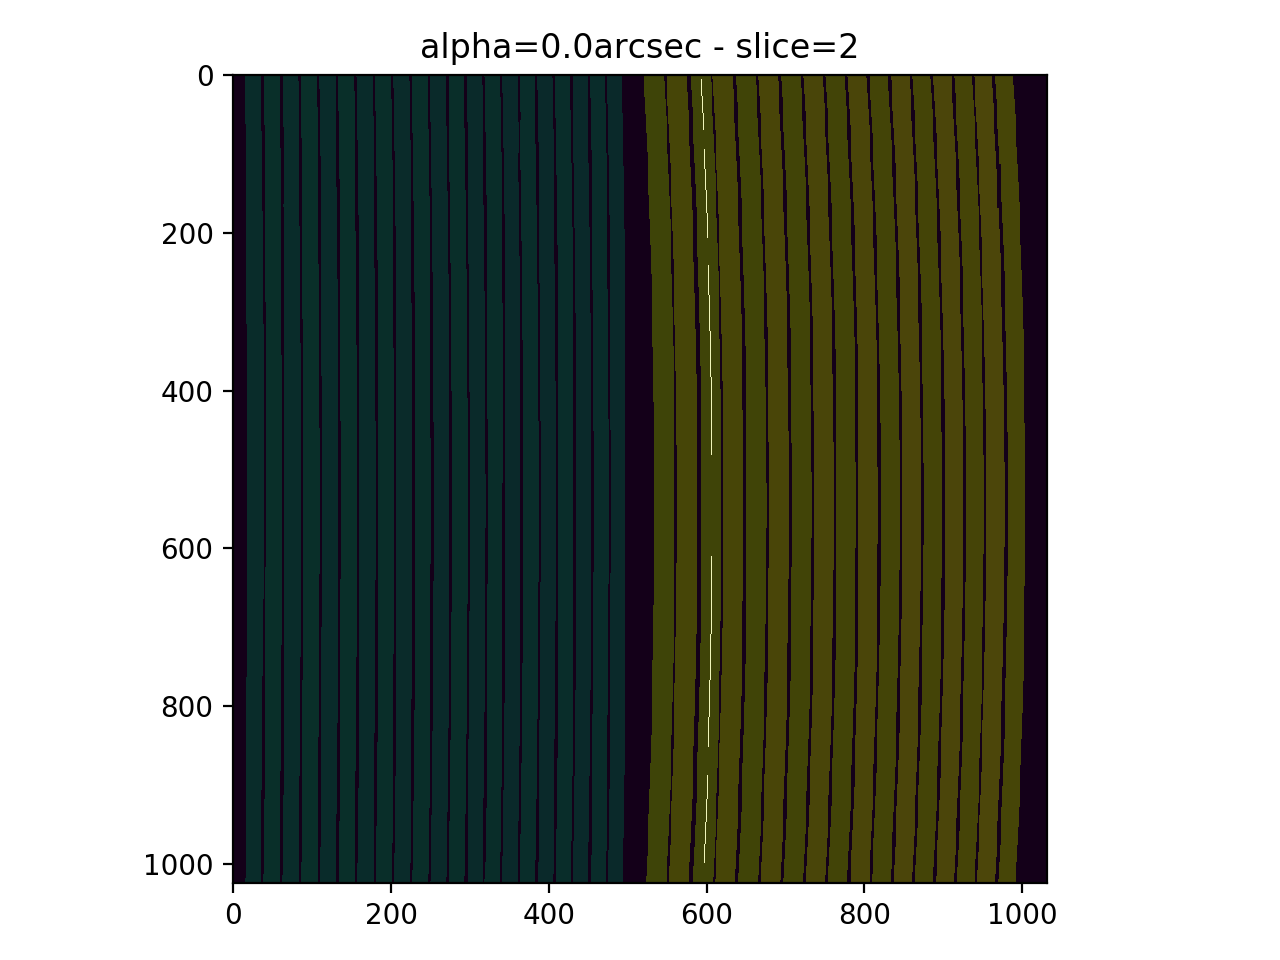

In [10]:
alpha_pos = alphas_inslice[0]

# Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified
ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)
if band == '1C':
    xpos[0] = xpos[1]
    xpos[-1] = xpos[-2]

valid_img = np.zeros(det_dims)
valid_img[ypos,xpos] = 1.
plt.figure()
plt.title("alpha={}arcsec - slice={}".format(round(alpha_pos,2),islice))
plt.imshow(sliceMap,zorder=0)
plt.imshow(valid_img,cmap='gray',alpha=0.7,zorder=1)
plt.tight_layout()

In [11]:
# Choose data regions
#--FM data
etalon1A_fm_data = etalon1A_img[ypos,xpos]
etalon1B_fm_data = etalon1B_img[ypos,xpos]

# Determine etalon peaks
#--FM Etalon_1A data
if user == 'yannis':
    etalon1A_fm_data[np.isnan(etalon1A_fm_data)] = -1
    FMetalon1A_peaks = funcs.find_peaks(etalon1A_fm_data,thres=thres_e1a,min_dist=min_dist_e1a)
    FMetalon1A_peaks = FMetalon1A_peaks[(FMetalon1A_peaks>1) & (FMetalon1A_peaks<1022)]
if user == 'alvaro':
    picos_1A, y_pixs_1A = funcs.find_max(etalon1A_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
    picos_inds_1A = y_pixs_1A-1
    FMetalon1A_peaks = picos_inds_1A.astype(int)
etalon1A_fm_data[(etalon1A_fm_data == -1)] = np.nan
etalon1A_fm_data_noNaN = etalon1A_fm_data.copy()
etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data)] = 0.

#--FM Etalon_1B data
if user == 'yannis':
    etalon1B_fm_data[np.isnan(etalon1B_fm_data)] = -1
    FMetalon1B_peaks = funcs.find_peaks(etalon1B_fm_data,thres=thres_e1b,min_dist=min_dist_e1b)
    FMetalon1B_peaks = FMetalon1B_peaks[(FMetalon1B_peaks>1) & (FMetalon1B_peaks<1022)]
if user == 'alvaro':
    picos_1B, y_pixs_1B = funcs.find_max(etalon1B_fm_data,np.arange(1,1025,1.),maxcut_1b,toler_1b) # maxcut, wavel_toler
    picos_inds_1B = y_pixs_1B-1
    FMetalon1B_peaks = picos_inds_1B.astype(int)
etalon1B_fm_data[(etalon1B_fm_data == -1)] = np.nan
etalon1B_fm_data_noNaN = etalon1B_fm_data.copy()
etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data)] = 0.

print("Number of identified etalon lines :     [alpha = "+str(alpha_pos)+"]\n FM ET_1A etalon data: {} lines \n FM ET_1B etalon data: {} lines".format(len(FMetalon1A_peaks),len(FMetalon1B_peaks)))

Number of identified etalon lines :     [alpha = 0.0]
 FM ET_1A etalon data: 64 lines 
 FM ET_1B etalon data: 74 lines


<IPython.core.display.Javascript object>


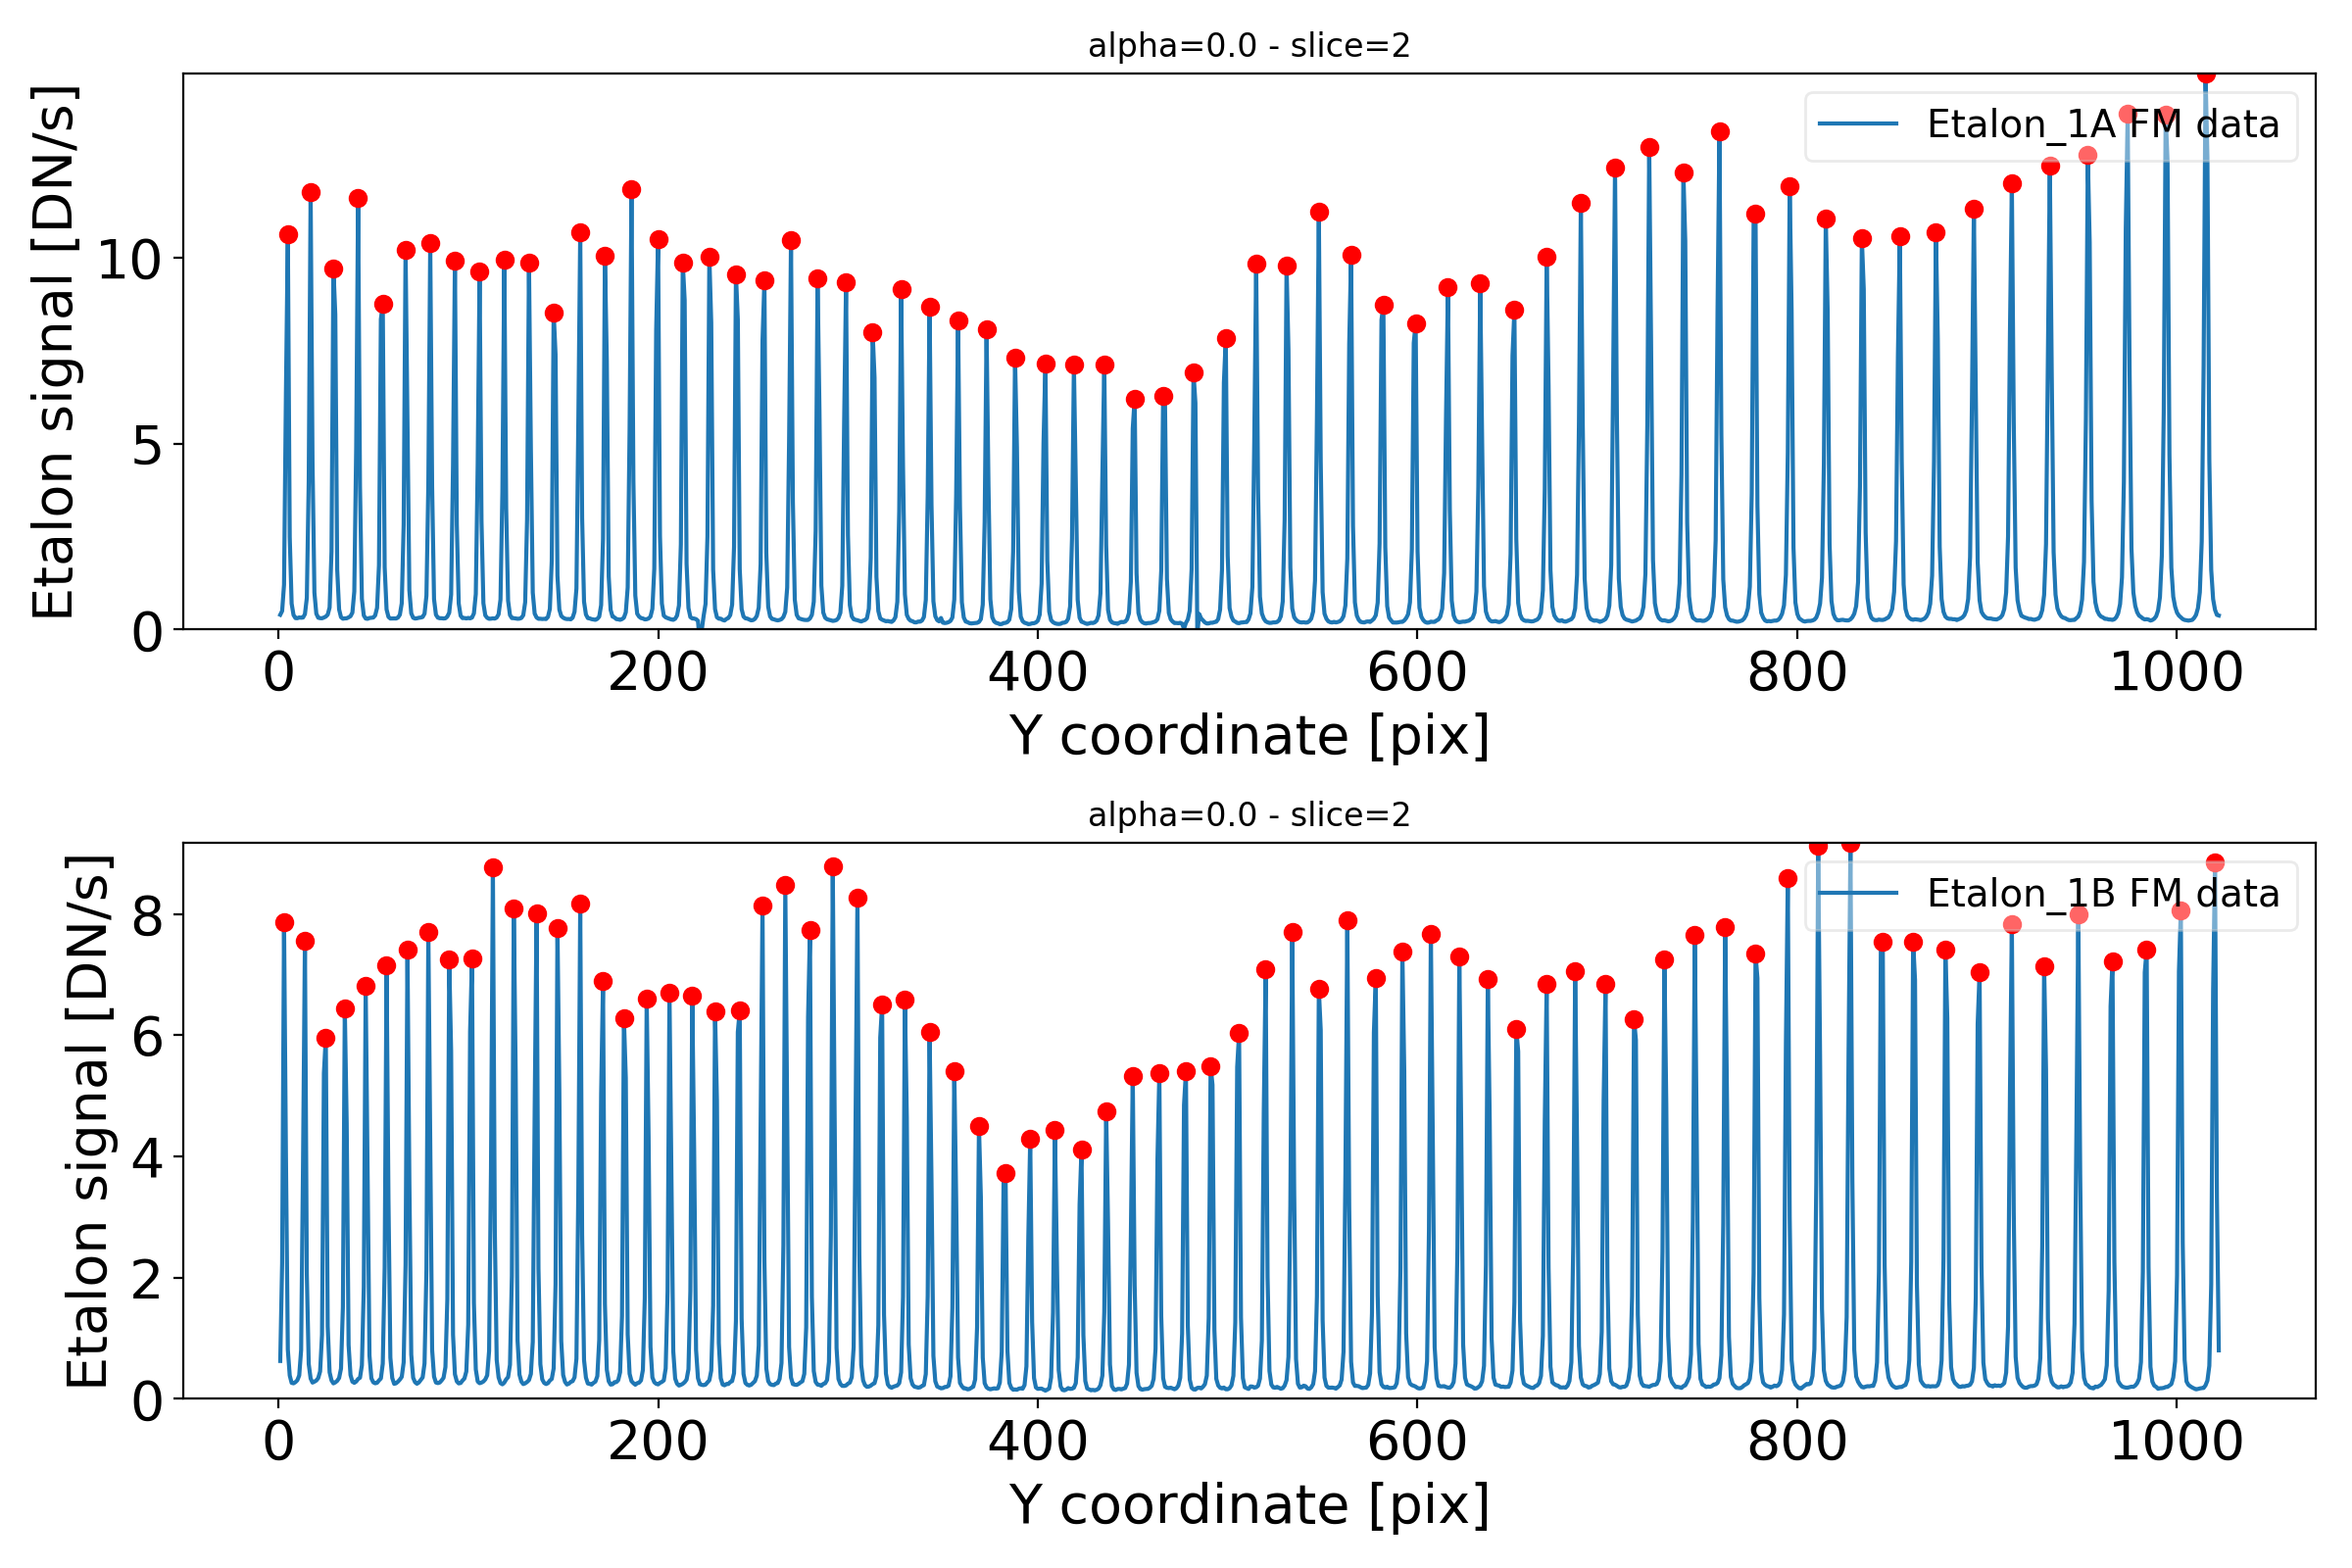

In [12]:
fig,axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(etalon1A_fm_data,label='Etalon_1A FM data')
axs[0].plot(FMetalon1A_peaks,etalon1A_fm_data[FMetalon1A_peaks],'ro')
axs[0].set_ylim(0,etalon1A_fm_data[~np.isnan(etalon1A_fm_data)].max())
axs[1].plot(etalon1B_fm_data,label='Etalon_1B FM data')
axs[1].plot(FMetalon1B_peaks,etalon1B_fm_data[FMetalon1B_peaks],'ro')
axs[1].set_ylim(0,etalon1B_fm_data[~np.isnan(etalon1B_fm_data)].max())
for plot in range(2):
    axs[plot].set_xlabel('Y coordinate [pix]',fontsize=20)
    axs[plot].set_ylabel('Etalon signal [DN/s]',fontsize=20)
    axs[plot].tick_params(axis='both',labelsize=20)
    axs[plot].legend(loc='upper right',framealpha=0.4,fontsize=14)
for plot in range(2): axs[plot].set_title("alpha="+str(alpha_pos)+' - slice='+str(islice))
plt.tight_layout()

In [13]:
FMetalon1A_fitparams,FMetalon1A_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1A_fm_data_noNaN,FMetalon1A_peaks,fit_func='skewed_voight',sigma0=1.5,f0=0.5,a0=0.1)
linecenter_ET1A = funcs.get_linecenter(FMetalon1A_fitparams,fitting_flag)
linefwhm_ET1A   = funcs.get_FWHM(FMetalon1A_fitparams,fitting_flag)
lineskew_ET1A   = funcs.get_skewness(FMetalon1A_fitparams,fitting_flag)

/Users/ioannisa/Desktop/python/miri_devel/funcs.py:984: RuntimeWarning: overflow encountered in square
  G_nu = (A/sigma) * np.sqrt(4*np.log(2)/np.pi) * np.exp(-4*np.log(2)*((x-mu)/sigma)**2)
/Users/ioannisa/Desktop/python/miri_devel/funcs.py:985: RuntimeWarning: overflow encountered in square
  L_nu = (2*A/(np.pi*sigma))/(1+4*((x-mu)/sigma)**2)


<IPython.core.display.Javascript object>


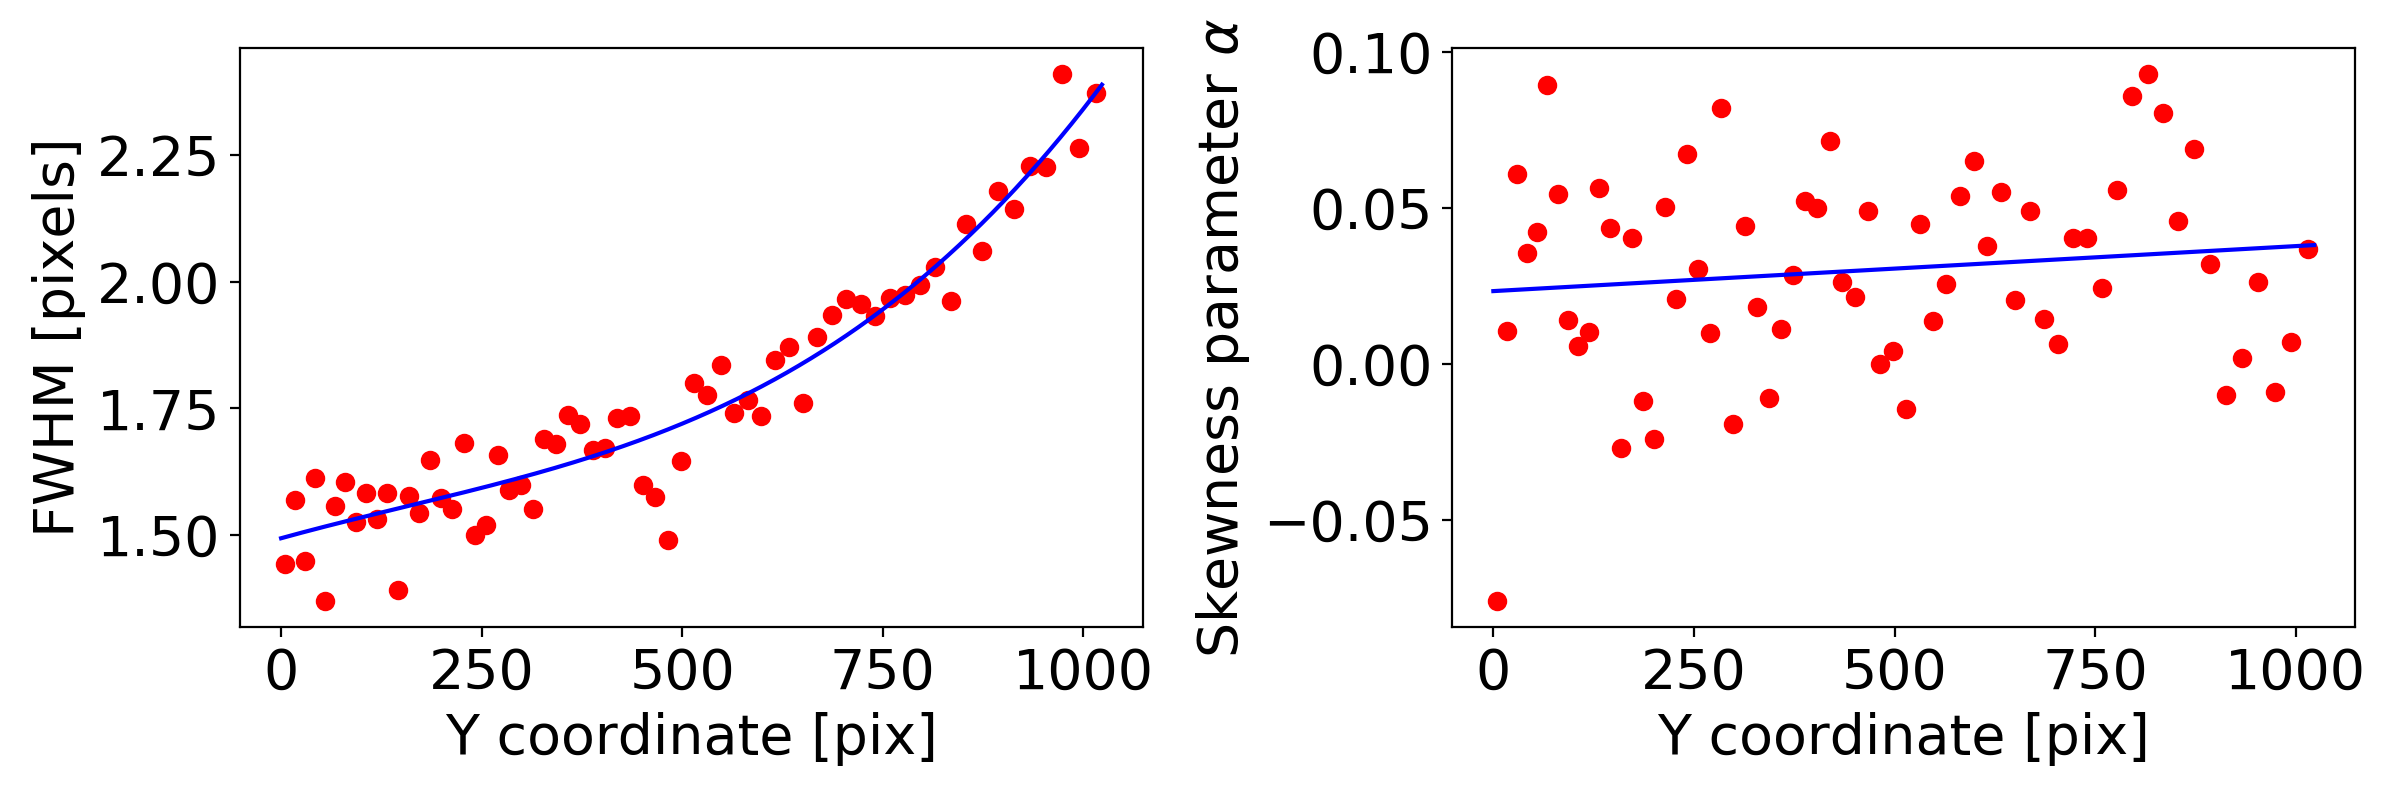

<IPython.core.display.Javascript object>


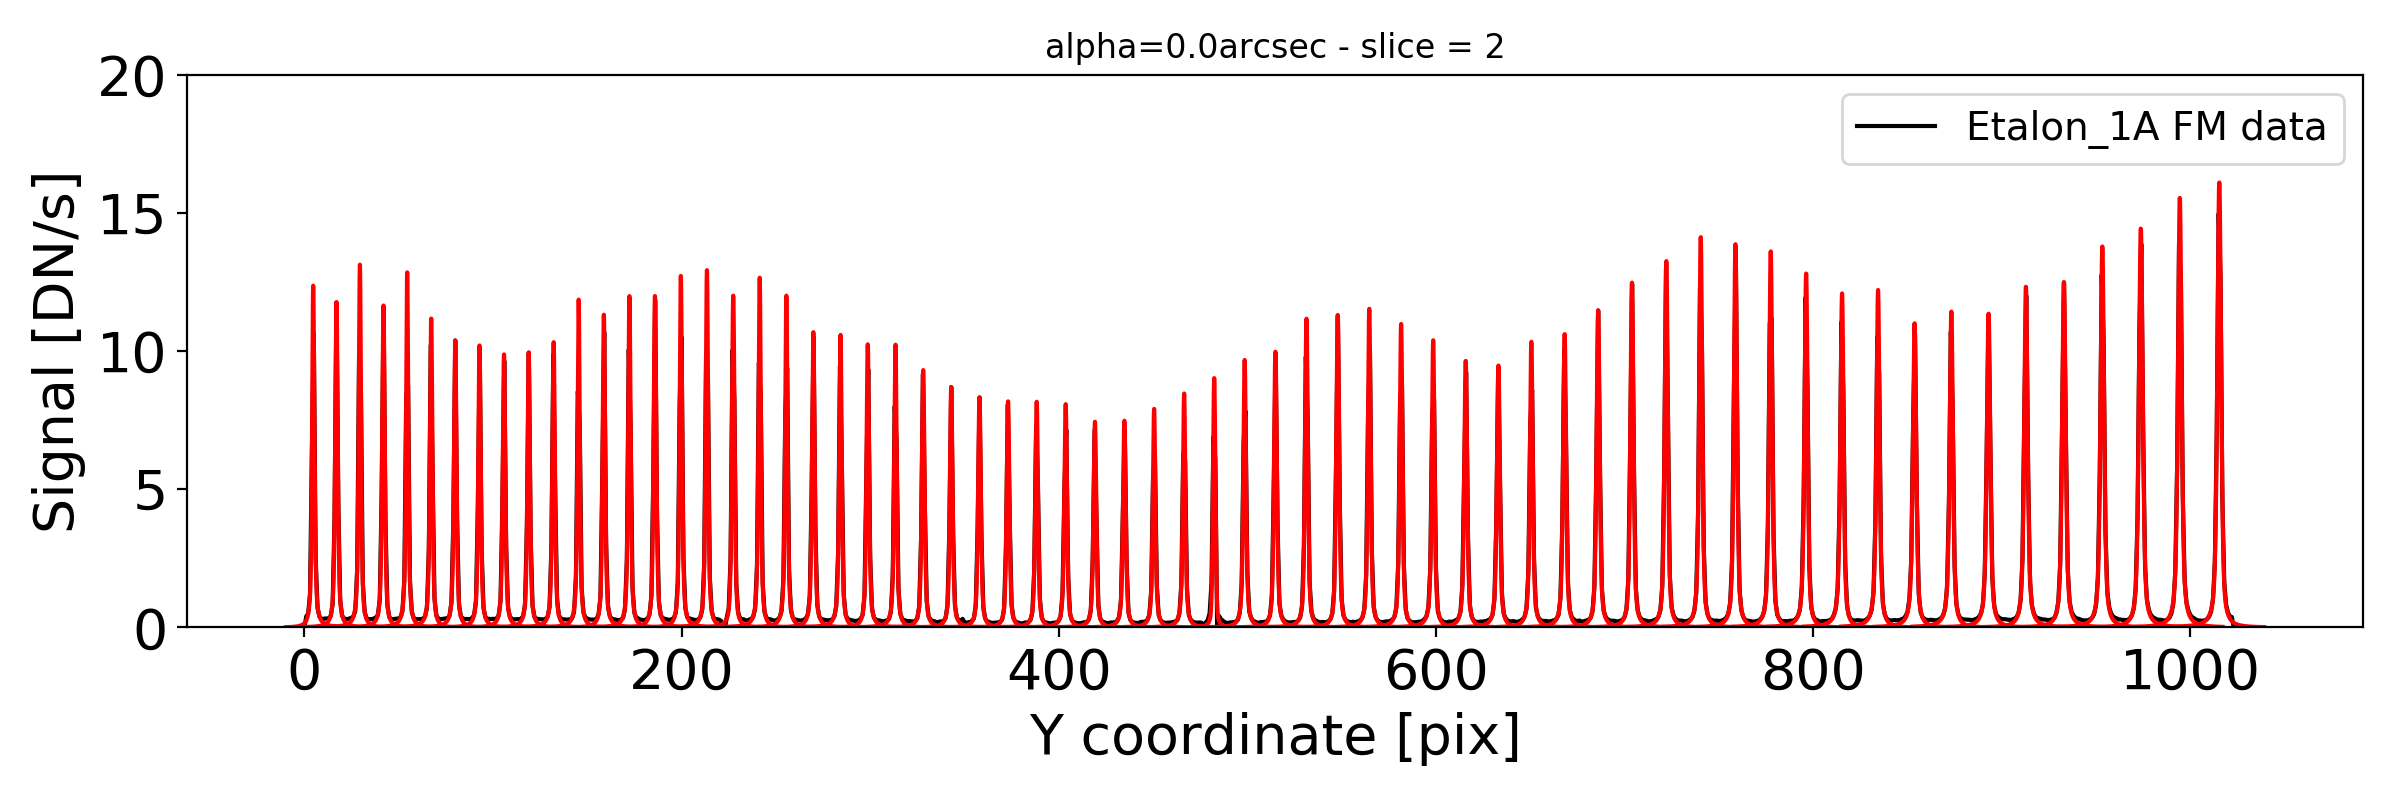

In [14]:
linecenter = linecenter_ET1A
linefwhm = linefwhm_ET1A
lineskew = lineskew_ET1A

sel1 = np.isfinite(np.array(linefwhm))
popt1,pcov1 = curve_fit(funcs.order3polyfit,np.array(linecenter)[sel1],np.array(linefwhm)[sel1] )
sel2 = np.isfinite(np.array(lineskew))
popt2,pcov2 = curve_fit(funcs.straight_line,np.array(linecenter)[sel2],np.array(lineskew)[sel2])

fig,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
axs[0].plot(np.arange(len(etalon1A_fm_data_noNaN)),funcs.order3polyfit(np.arange(len(etalon1A_fm_data_noNaN)),*popt1),'b')
axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
axs[1].plot(np.arange(len(etalon1A_fm_data_noNaN)),funcs.straight_line(np.arange(len(etalon1A_fm_data_noNaN)),*popt2),'b')
axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

# Plot the fits
plt.figure(figsize=(12,4))
plt.plot(etalon1A_fm_data_noNaN,'k',label='Etalon_1A FM data')
#plt.vlines(cutoffpix,0,25,linestyle='dashed',label='reference point')
funcs.plot_etalon_fit(FMetalon1A_fitparams,fitting_flag)
plt.ylim(0,20)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

In [15]:
FMetalon1B_fitparams,FMetalon1B_fiterrors,fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1B_fm_data_noNaN,FMetalon1B_peaks,fit_func='skewed_voight',sigma0=5,f0=0.5,a0=0.1)

linecenter_ET1B = funcs.get_linecenter(FMetalon1B_fitparams,fitting_flag)
linefwhm_ET1B   = funcs.get_FWHM(FMetalon1B_fitparams,fitting_flag)
lineskew_ET1B   = funcs.get_skewness(FMetalon1B_fitparams,fitting_flag)

<IPython.core.display.Javascript object>


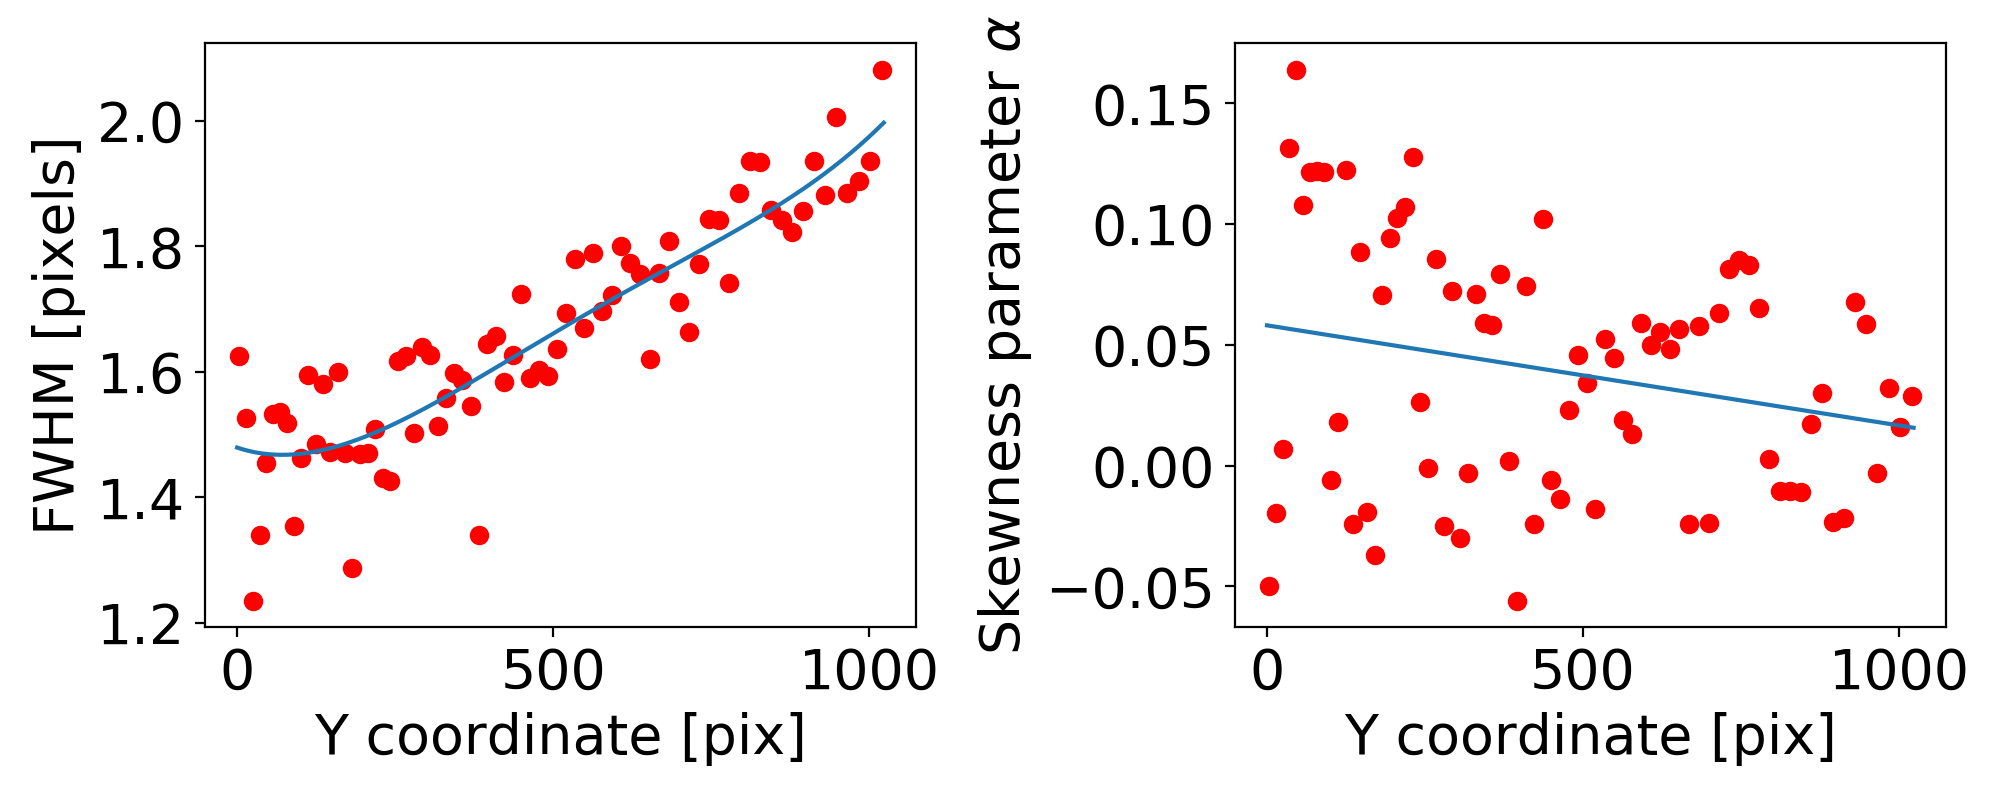

<IPython.core.display.Javascript object>


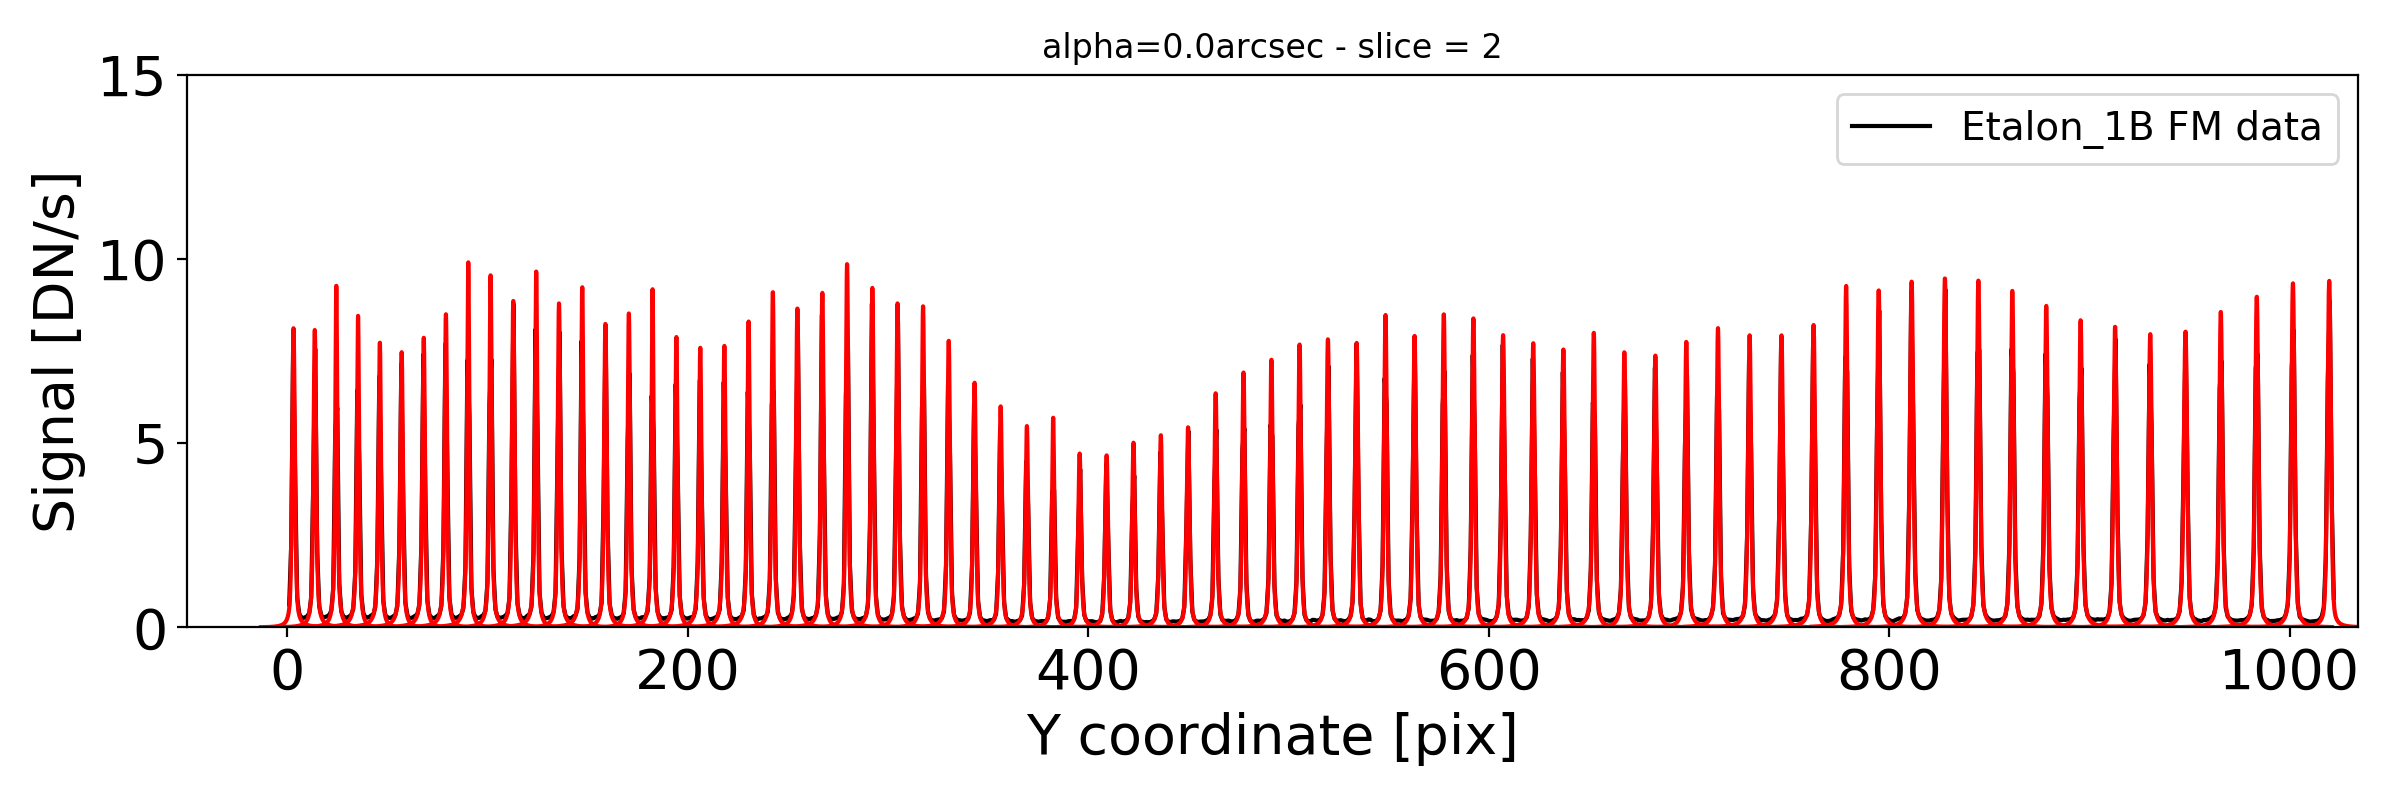

In [16]:
##### > Plot the results / sanity checks  ET_1B
linecenter = linecenter_ET1B
linefwhm = linefwhm_ET1B
lineskew = lineskew_ET1B

sel1 = np.isfinite(np.array(linefwhm))
popt1,pcov1 = curve_fit(funcs.order4polyfit,np.array(linecenter)[sel1],np.array(linefwhm)[sel1] )
sel2 = np.isfinite(np.array(lineskew))
popt2,pcov2 = curve_fit(funcs.straight_line,np.array(linecenter)[sel2],np.array(lineskew)[sel2])

fig,axs = plt.subplots(1,2,figsize=(10,4))
axs[0].plot(np.array(linecenter)[sel1],np.array(linefwhm)[sel1],'ro')
axs[0].plot(np.arange(det_dims[0]),funcs.order4polyfit(np.arange(det_dims[0]),*popt1))
axs[0].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[0].set_ylabel(r'FWHM [pixels]',fontsize=20)
axs[0].tick_params(axis='both',labelsize=20)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axs[1].plot(np.array(linecenter)[sel2],np.array(lineskew)[sel2],'ro')
axs[1].plot(np.arange(det_dims[0]),funcs.straight_line(np.arange(det_dims[0]),*popt2))
axs[1].set_xlabel('Y coordinate [pix]',fontsize=20)
axs[1].set_ylabel(r'Skewness parameter $\alpha$',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.tight_layout()

plt.figure(figsize=(12,4))
plt.plot(etalon1B_fm_data,'k',label='Etalon_1B FM data')
funcs.plot_etalon_fit(FMetalon1B_fitparams,fitting_flag)
plt.xlim(-50,1034)
plt.ylim(0,15)
plt.xlabel('Y coordinate [pix]',fontsize=20)
plt.ylabel('Signal [DN/s]',fontsize=20)
plt.title("alpha={}arcsec - slice = {}".format(str(alpha_pos),islice))
plt.tick_params(axis='both',labelsize=20)
plt.legend(loc='upper right',fontsize=14)
plt.tight_layout()

### Perform analysis for all alphas in slice

In [17]:
plot = False
for alpha_pos in alphas_inslice:
    if alpha_pos == alphas_inslice[0]:
        print 'Along-slice position:'
    print  '                     {} arcsec'.format(round(alpha_pos,2))
    # Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)
    if band == '1C':
        xpos[0] = xpos[1]
        xpos[-1] = xpos[-2]
        
    # Choose data regions
    #--FM data
    etalon1A_fm_data = etalon1A_img[ypos,xpos]
    etalon1B_fm_data = etalon1B_img[ypos,xpos]

    # Determine etalon peaks
    #--FM Etalon_1A data
    if user == 'yannis':
        etalon1A_fm_data[np.isnan(etalon1A_fm_data)] = -1
        FMetalon1A_peaks = funcs.find_peaks(etalon1A_fm_data,thres=thres_e1a,min_dist=min_dist_e1a)
        FMetalon1A_peaks = FMetalon1A_peaks[(FMetalon1A_peaks>1) & (FMetalon1A_peaks<1022)]
    if user == 'alvaro':
        picos_1A, y_pixs_1A = funcs.find_max(etalon1A_fm_data,np.arange(1,1025,1.),maxcut_1a,toler_1a) # maxcut, wavel_toler
        picos_inds_1A = y_pixs_1A-1
        FMetalon1A_peaks = picos_inds_1A.astype(int)
    etalon1A_fm_data[(etalon1A_fm_data == -1)] = np.nan
    etalon1A_fm_data_noNaN = etalon1A_fm_data.copy()
    etalon1A_fm_data_noNaN[np.isnan(etalon1A_fm_data)] = 0.

    #--FM Etalon_1B data
    if user == 'yannis':
        etalon1B_fm_data[np.isnan(etalon1B_fm_data)] = -1
        FMetalon1B_peaks = funcs.find_peaks(etalon1B_fm_data,thres=thres_e1b,min_dist=min_dist_e1b)
        FMetalon1B_peaks = FMetalon1B_peaks[(FMetalon1B_peaks>1) & (FMetalon1B_peaks<1022)]
    if user == 'alvaro':
        picos_1B, y_pixs_1B = funcs.find_max(etalon1B_fm_data,np.arange(1,1025,1.),maxcut_1b,toler_1b) # maxcut, wavel_toler
        picos_inds_1B = y_pixs_1B-1
        FMetalon1B_peaks = picos_inds_1B.astype(int)
    etalon1B_fm_data[(etalon1B_fm_data == -1)] = np.nan
    etalon1B_fm_data_noNaN = etalon1B_fm_data.copy()
    etalon1B_fm_data_noNaN[np.isnan(etalon1B_fm_data)] = 0.
    
    # Fit Etalon_1A lines in FM data
    FMetalon1A_fitparams,FMetalon1A_fiterrors,ET1A_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1A_fm_data_noNaN,FMetalon1A_peaks,fit_func='skewed_voight',sigma0=1.5,f0=0.5,a0=0.1)
    linecenter_ET1A = funcs.get_linecenter(FMetalon1A_fitparams,ET1A_fitting_flag)
    linefwhm_ET1A   = funcs.get_FWHM(FMetalon1A_fitparams,ET1A_fitting_flag)
    lineskew_ET1A   = funcs.get_skewness(FMetalon1A_fitparams,ET1A_fitting_flag)
    
    # Fit Etalon_1B lines in FM data
    FMetalon1B_fitparams,FMetalon1B_fiterrors,ET1B_fitting_flag,range_ini,range_fin = funcs.fit_etalon_lines(np.arange(det_dims[0]),etalon1B_fm_data_noNaN,FMetalon1B_peaks,fit_func='skewed_voight',sigma0=5,f0=0.5,a0=0.1)
    linecenter_ET1B = funcs.get_linecenter(FMetalon1B_fitparams,ET1B_fitting_flag)
    linefwhm_ET1B   = funcs.get_FWHM(FMetalon1B_fitparams,ET1B_fitting_flag)
    lineskew_ET1B   = funcs.get_skewness(FMetalon1B_fitparams,ET1B_fitting_flag)

    if plot is True:
        plt.figure(figsize=(12,4))
        plt.plot(etalon1A_fm_data,'k',label='Etalon_1A FM data')
        funcs.plot_etalon_fit(FMetalon1A_fitparams,ET1A_fitting_flag)
        plt.ylim(0,16)
        plt.xlabel('Y coordinate [pix]',fontsize=20)
        plt.ylabel('Signal [DN/s]',fontsize=20)
        plt.title("alpha={}arcsec - slice = {}".format(round(alpha_pos,2),islice))
        plt.tick_params(axis='both',labelsize=20)
        plt.legend(loc='upper right',fontsize=14)
        plt.tight_layout()
        plt.savefig('figures/ET1A_slice{}alpha{}.png'.format(islice,round(alpha_pos,2)))
        plt.close()

        plt.figure(figsize=(12,4))
        plt.plot(etalon1B_fm_data,'k',label='Etalon_1B FM data')
        funcs.plot_etalon_fit(FMetalon1B_fitparams,ET1B_fitting_flag)
        plt.ylim(0,16)
        plt.xlabel('Y coordinate [pix]',fontsize=20)
        plt.ylabel('Signal [DN/s]',fontsize=20)
        plt.title("alpha={}arcsec - slice = {}".format(round(alpha_pos,2),islice))
        plt.tick_params(axis='both',labelsize=20)
        plt.legend(loc='upper right',fontsize=14)
        plt.tight_layout()
        plt.savefig('figures/ET1B_slice{}alpha{}.png'.format(islice,round(alpha_pos,2)))
        plt.close()
    
    # SAVES fits of FM - ETALON 1A
    for zzz in range(0,np.size(FMetalon1A_peaks),1):
        save_et1a.write(str(alpha_pos)+'  '+str(xpos[FMetalon1A_peaks[zzz]])+'  '+str(FMetalon1A_peaks[zzz])+'  '+str(linecenter_ET1A[zzz])+'  '+str(linefwhm_ET1A[zzz])+'  '+str(lineskew_ET1A[zzz])+'\n')

    # SALVA fits of FM - ETALON 1B
    for zzz in range(0,np.size(FMetalon1B_peaks),1):
        save_et1b.write(str(alpha_pos)+'  '+str(xpos[FMetalon1B_peaks[zzz]])+'  '+str(FMetalon1B_peaks[zzz])+'  '+str(linecenter_ET1B[zzz])+'  '+str(linefwhm_ET1B[zzz])+'  '+str(lineskew_ET1B[zzz])+'\n')
    
save_et1a.close()
save_et1b.close()

Along-slice position:
                     0.0 arcsec
                     -1.76 arcsec
                     -1.58 arcsec
                     -1.4 arcsec
                     -1.23 arcsec
                     -1.05 arcsec
                     -0.87 arcsec
                     -0.69 arcsec
                     -0.51 arcsec
                     -0.34 arcsec
                     -0.16 arcsec
                     0.02 arcsec
                     0.2 arcsec
                     0.38 arcsec
                     0.55 arcsec
                     0.73 arcsec
                     0.91 arcsec
                     1.09 arcsec
                     1.26 arcsec
                     1.44 arcsec
                     1.62 arcsec
                     1.8 arcsec
                     1.98 arcsec
                     2.15 arcsec
